C:\Users\Jatin Shishodia\AppData\Local\Temp\ipykernel_20224\116564750.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


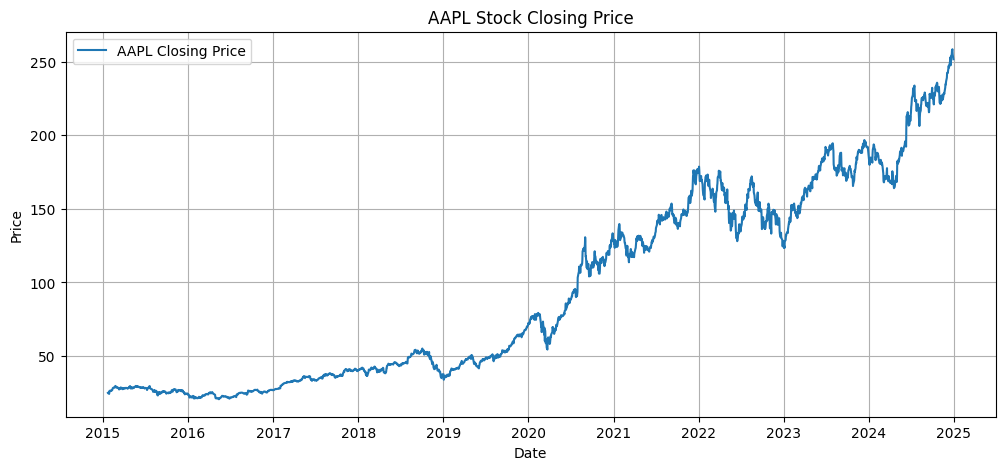

Input shape: (2442, 60, 3), Target shape: (2442,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0212 - val_loss: 0.0012
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4964e-04 - val_loss: 0.0015
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3099e-04 - val_loss: 0.0015
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1547e-04 - val_loss: 0.0012
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1939e-04 - val_loss: 0.0014
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9055e-04 - val_loss: 9.2601e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0388e-04 - val_loss: 6.8669e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9859e-04 - val_loss: 0.0018
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8424e-04 - val_loss: 0.0010
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8687e-04 - val_loss: 6.2250e-04
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0315e-04 - val_loss: 6.1226e-04
Epoch 1

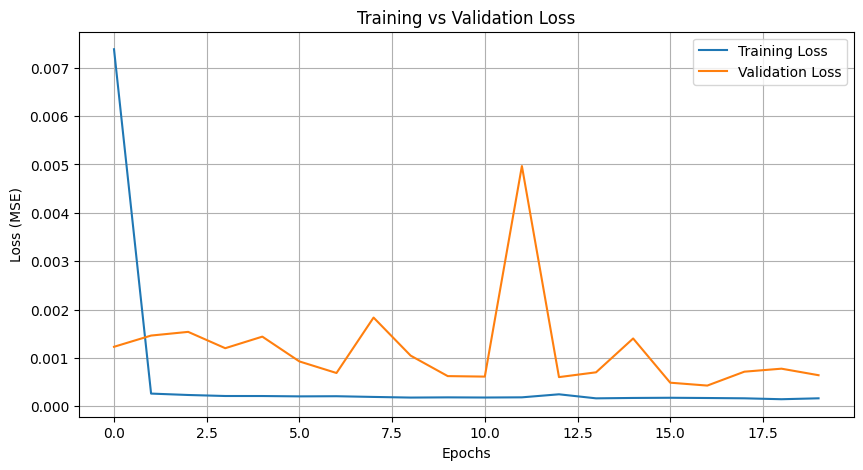

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


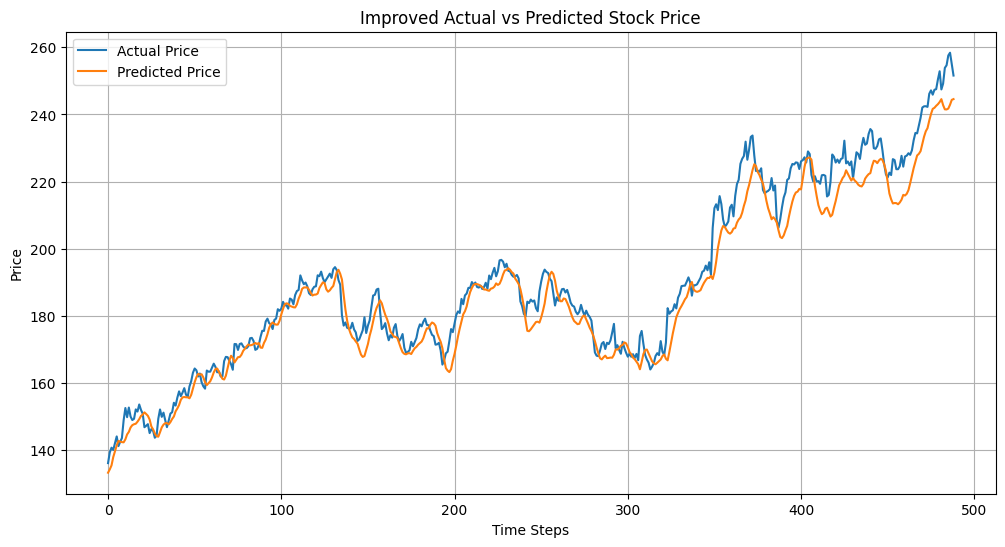

RMSE: 6.02
MAE: 4.65
R² Score: 0.95


In [2]:
# Step 1: Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 2: Fetch Stock Data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31'

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']]

# Add 14-day Moving Average
df['MA14'] = df['Close'].rolling(window=14).mean()

# Calculate RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])

# Drop rows with NaNs (from MA14 and RSI)
df.dropna(inplace=True)

# Step 3: Visualize Closing Prices
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='AAPL Closing Price')
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('price_plot.png')
plt.show()

# Step 4: Data Normalization
features = ['Close', 'MA14', 'RSI']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Step 5: Create Sequences
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # target is original 'Close' column
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

# Step 6: Train-Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 7: Build LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # should be (60, 3)
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Step 8: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# Step 9: Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

# Step 10: Make Predictions
y_pred_scaled = model.predict(X_test)

# Inverse scale only Close price (1st column)
def inverse_transform_column(scaled_column):
    padded = np.concatenate([scaled_column, np.zeros((len(scaled_column), 2))], axis=1)
    return scaler.inverse_transform(padded)[:, 0]

y_test_unscaled = inverse_transform_column(y_test.reshape(-1, 1))
y_pred_unscaled = inverse_transform_column(y_pred_scaled)

# Step 11: Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Price')
plt.plot(y_pred_unscaled, label='Predicted Price')
plt.title('Improved Actual vs Predicted Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted_with_indicators.png')
plt.show()


rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

model.save("lstm_model.h5")